# 0. Imports

### 0.1 Libs

In [71]:
import warnings
import inflection
import re

import numpy    as np
import pandas   as pd
import seaborn  as sns
import nbformat
import umap.umap_ as umap


from IPython.display        import Image
from scipy                  import stats            as ss
from plotly                 import express          as px
from matplotlib             import pyplot           as plt
from sklearn                import cluster          as c
from sklearn                import metrics          as m
from sklearn                import preprocessing    as pp

from yellowbrick.cluster    import KElbowVisualizer, SilhouetteVisualizer

### 0.2 Helper Functions

In [2]:
warnings.simplefilter("ignore")

def numerical_metrics(numerical_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    d_min = pd.DataFrame(numerical_attributes.apply(min)).T
    d_max = pd.DataFrame(numerical_attributes.apply(max)).T
    d_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    m = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    m.columns=['Attributes','Min','Max','Range','Mean','Median','STD','Skew','Kurtosis']

    return m

# Cramér's V
def cramer_v(x,y):
    cm = pd.crosstab( x, y).values               
    n = cm.sum()                                 
    r, k = cm.shape                             
    chi2 = ss.chi2_contingency(cm)[0]

    chi2corr = max( 0, chi2 - ((k-1)*(r-1))/(n-1) )
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)

    # Cálculo do Cramér's V:
    return np.sqrt ( (chi2corr/n) / (min(kcorr-1, rcorr-1)) )



### 0.3 Loading Data

In [3]:
df_raw = pd.read_csv('../data/data.csv', encoding= 'unicode_escape')

# 1. Data Description

### 1.0 Rename Columns

In [4]:
df1 = df_raw.copy()

df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old))

df1.columns = cols_new

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 1.1 Data Dimentions

In [6]:
print(f'Number of Rows:{df1.shape[0]}')
print(f'Number of Columns:{df1.shape[1]}')

Number of Rows:541909
Number of Columns:8


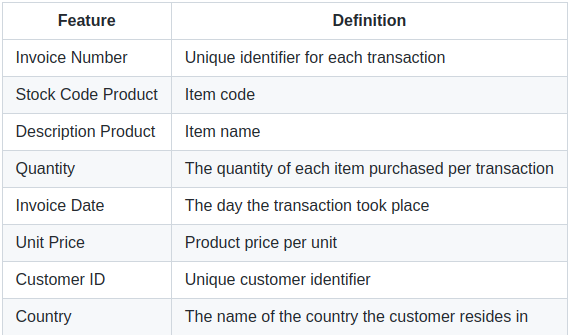

In [7]:
Image('../image/features_description.png')

### 1.2 Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.3 Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.4 Fillout NA

In [10]:
# Para avançar com o projeto de forma rápida, vamos retirar os registros com valores faltantes. 
# Posteriormente serão analisadas outras possibilidades de tratar esses dados.

df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.0%}'.format( 1-(df1.shape[0] / df_raw.shape[0])))
print(f'New number of rows: {df1.shape[0]}')

Removed data: 25%
New number of rows: 406829


### 1.5 Change Types

In [11]:
df1['customer_id'] = df1['customer_id'].astype(int)
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'])

In [12]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

### 1.6 Descriptive Statistics

#### 1.6.0  Datasets

In [34]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])


#### 1.6.1 Nummerical Attributes

In [35]:
numerical_metrics(num_attributes)

,Attributes,Min,Max,Range,Mean,Median,STD,Skew,Kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


<font color = 'red'> Attention Points </font>

1. Negative Quantity
2. Unit price equal zero

#### 1.6.2 Categorical Attributes

In [36]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [39]:
# The invoice_no should be a number
len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates())

3654

In [46]:
# The stock_code should be a number
cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()


array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

In [48]:
len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates())


886

# 2. Data Filtering 

In [59]:
df2 = df1.copy()

In [60]:
# ==== Num Attributes ====

# Unit Price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.010, :]

# Stock Code != ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK', 'C2'])]

# Description

# Quantity
df_returns = df2.loc[df2['quantity']<0, :]
df_purchase = df2.loc[df2['quantity']>0, :]

# 3. Feature Engineering

### 3.1 News Features

In [61]:
df3 = df2.copy()

In [62]:
# Data Reference
df_ref = df3.drop (['invoice_no', 'stock_code', 'description',
                    'quantity', 'invoice_date', 'unit_price',
                    'country'], axis=1).drop_duplicates(ignore_index=True)

In [63]:
# Monetary (Gross Revenue)
df_purchase['gross_revenue'] = df_purchase['quantity'] * df_purchase['unit_price']
df_monetary = df_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge (df_ref, df_monetary, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id       0
gross_revenue    27
dtype: int64

In [64]:
# Recency
df_recency = df_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [65]:
# Frequency
df_freq = df_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on = 'customer_id', how = 'left')

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [66]:
# Avg Ticket
df_avg_ticket = df_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [67]:
# Return Number
df_returns = df_returns[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no' : 'returns'})
df_ref = pd.merge(df_ref, df_returns, how = 'left', on='customer_id')
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
returns           0
dtype: int64

In [68]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,5391.21,371.0,34.0,18.152222,1.0
1,13047,3232.59,56.0,9.0,18.904035,7.0
2,12583,6705.38,2.0,15.0,28.902500,2.0
3,13748,948.25,95.0,5.0,33.866071,0.0
4,15100,876.00,333.0,3.0,292.000000,3.0


# 4. Exploratory Data Analysis

In [70]:
df4 = df_ref.dropna().copy()

df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
returns          0
dtype: int64

# 5. Data Preparation

In [72]:
df5 = df4.copy()

df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,5391.21,371.0,34.0,18.152222,1.0
1,13047,3232.59,56.0,9.0,18.904035,7.0
2,12583,6705.38,2.0,15.0,28.902500,2.0
3,13748,948.25,95.0,5.0,33.866071,0.0
4,15100,876.00,333.0,3.0,292.000000,3.0


In [73]:
# Standatization

ss = pp.StandardScaler()

df5['gross_revenue']    = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days']     = ss.fit_transform(df5[['recency_days']])
df5['invoice_no']       = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket']       = ss.fit_transform(df5[['avg_ticket']])
df5['returns']          = ss.fit_transform(df5[['returns']])


# 6. Feature Selection

In [74]:
df6 = df5.copy()

# 7. Hyperparameter Fine-Tunning

### 7.0 Dataset

In [75]:
df6.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns
0,17850,0.378436,2.787476,3.895526,-0.033909,0.114969
1,13047,0.136044,-0.356391,0.622248,-0.033397,3.160125
2,12583,0.526004,-0.895340,1.407834,-0.026588,0.622495
3,13748,-0.120464,0.032849,0.098523,-0.023208,-0.392557
4,15100,-0.128577,2.408216,-0.163339,0.152580,1.130021


In [76]:
df7 = df6.drop(columns = ['customer_id'])

### 7.1 Within-Cluster Sum of Square (WSS)

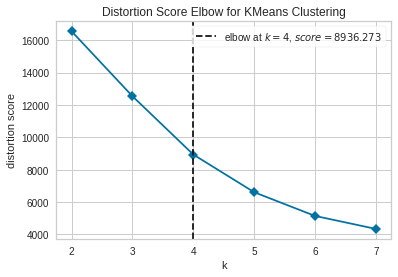

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [77]:
clusters = [2, 3, 4, 5, 6, 7]

# model definition
kmeans = KElbowVisualizer(c.KMeans(),
                          k = clusters,
                          timings = False)
# model training
kmeans.fit ( df7 )

# plot
kmeans.show()

### 7.2 Silhouette Score

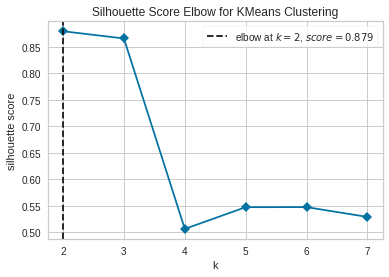

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [78]:
# Yellow Brick

# model definition
kmeans = KElbowVisualizer(c.KMeans(),
                          k = clusters,
                          metric='silhouette',
                          timings = False)

# model training
kmeans.fit ( df7 )

# plot
kmeans.show()

### 7.3 Silhouette Analysis

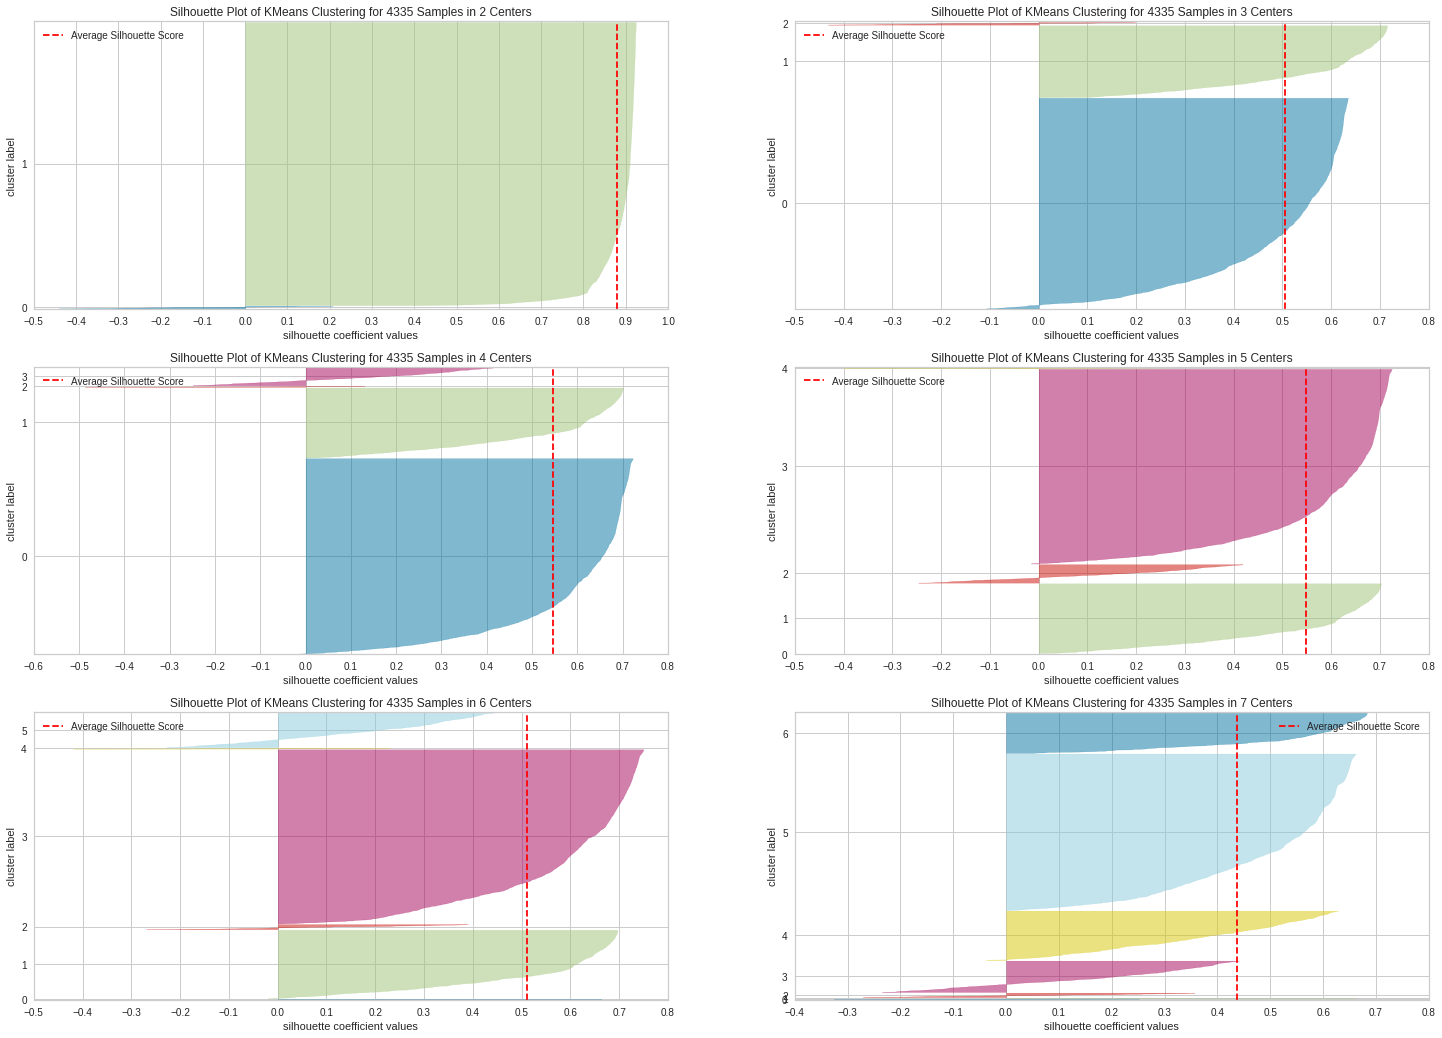

In [79]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k,
                    init='random',
                    n_init=10,
                    max_iter=100,
                    random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df7)
    visualizer.finalize()

# 8. Machine Learning Modelling

### 8.1 K-Means

In [80]:
X = df7.copy()

In [81]:
# model definition
k=6
kmeans = c.KMeans(init='random',
                  n_clusters=k,
                  n_init=10,
                  max_iter=300,
                  random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.2 Cluster Validation

In [82]:
# WSS
print(f'WSS Value:{kmeans.inertia_}')

# SS
print('SS Value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS Value:5853.717409761797
SS Value: 0.5117312089708806


# 9. Evaluation - Cluster Analysis

### 9.1 Visualization Inspection

In [83]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns,cluster
0,17850,0.378436,2.787476,3.895526,-0.033909,0.114969,1
1,13047,0.136044,-0.356391,0.622248,-0.033397,3.160125,5
2,12583,0.526004,-0.895340,1.407834,-0.026588,0.622495,5
3,13748,-0.120464,0.032849,0.098523,-0.023208,-0.392557,3
4,15100,-0.128577,2.408216,-0.163339,0.152580,1.130021,1


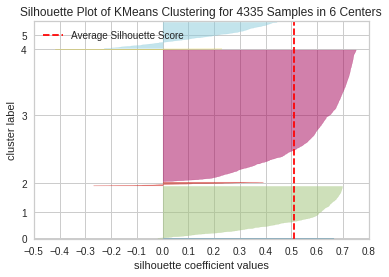

In [84]:
# Silhouette Viz:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

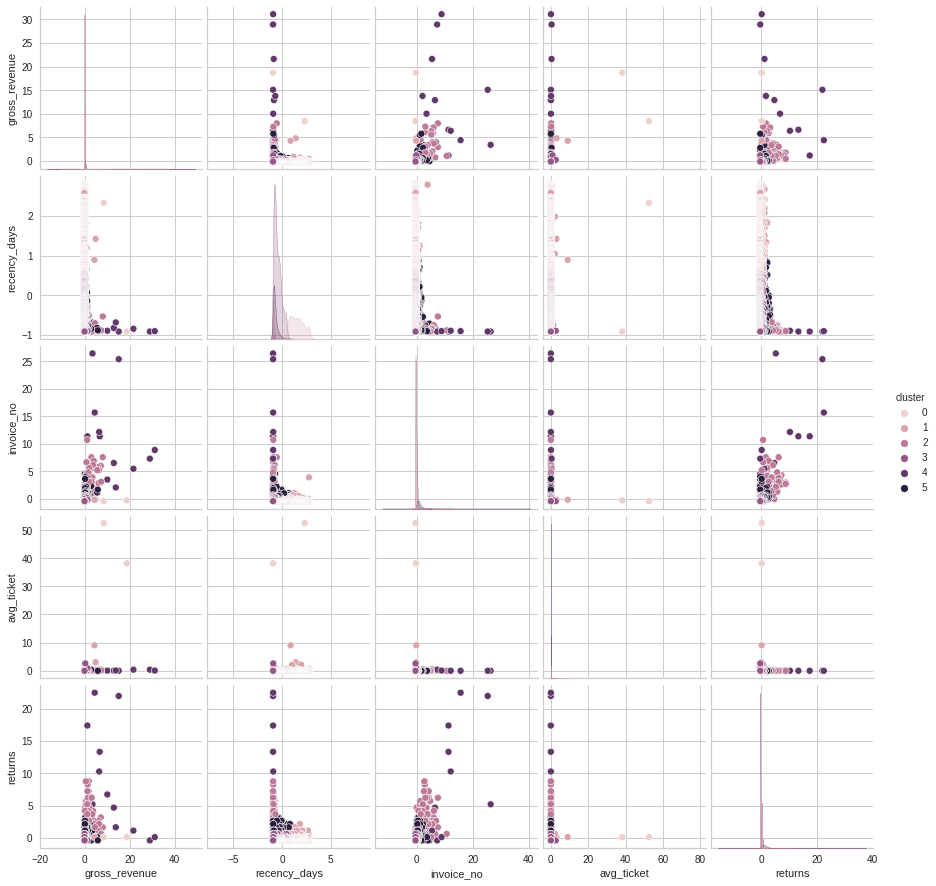

In [85]:
# 2D Plot (Pair Plot)
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

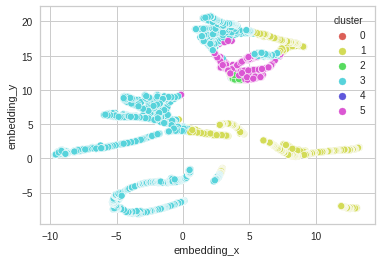

In [87]:
# UMAP (mais rápido para grandes quantidades de dados) / t-SNE (mais preciso, porém mais lento): 
    # abordagem por Manifold (topologia) - projeção de altas dimensões em 3D ou 2D sem perder suas características principais

reducer = umap.UMAP(n_neighbors=40, random_state=42)
embedding = reducer.fit_transform (X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plto UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 hue='cluster',
                 palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                 data = df_viz)

### 9.2 Cluster Profile

In [31]:
df9.head()

,customer_id,recency_days,invoice_no,gross_revenue,avg_ticket,cluster
0,17850,301,35,5288.63,16.950737,3
1,13047,31,18,3079.10,15.709694,0
2,12583,2,18,7187.34,28.634821,3
3,13748,95,5,948.25,33.866071,0
4,15100,329,6,635.10,105.850000,0


In [32]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100

# Avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on = 'cluster')

# Avg recency
df_avg_recency = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')


df_cluster


,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4071,93.115279,946.696250,96.429870,3.641120,25.359654
1,1,6,0.137237,182181.981667,6.666667,89.000000,253.626345
2,2,28,0.640439,42614.387143,5.678571,57.821429,162.862605
3,3,267,6.107045,8089.028652,19.823970,19.528090,62.783157


Cluster 01 (Candidado a Insider):
- Total Customers: 6 (0,14% of total)
- Avg Recency: 7 days
- Avg frequency: 89 purchase
- Avg Revenue: $ 182,181.98

Cluster 02:
- Total Customers: 31 (0,71% of total)
- Avg Recency: 14 days
- Avg frequency: 53 purchase
- Avg Revenue: $ 40,543.52

Cluster 03:
- Total Customers: 4,335 (99% of total)
- Avg Recency: 92 days
- Avg frequency: 5 purchase
- Avg Revenue: $ 1,372.58

# 10. Deploy To Production